In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader, Subset, random_split, Dataset
import torch.nn.utils.weight_norm as weight_norm
import torch.nn.functional as F
import numpy as np
import scipy as sp
from scipy.stats import norm, shapiro, binom
from scipy.special import beta

import matplotlib.pyplot as plt
import random
import time as t
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype, fetch_openml, fetch_20newsgroups
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
import os
import urllib
import gzip
import zipfile
import json
from datetime import datetime

from sklearn.feature_extraction.text import TfidfVectorizer
import datasets
from datasets import load_dataset
import seaborn as sns
import ipynbname
from collections import defaultdict

notebook_name = ipynbname.name()
# from torchtime.data import PhysioNet2012
# from torchtime.collate import packed_sequence

In [2]:
# ✅ 1. Config

device_id = 4
device = "cuda:"+str(device_id) if torch.cuda.is_available() else 'cpu'

BATCH_SIZE = 128
DATA_PATH = './data'
SEED = 42
torch.manual_seed(SEED)

the_dataset = "CT"

if the_dataset == "H":
    # Step 1: Load the data
    file_path = "~/dataset.txt"  # Replace with actual path
    df = pd.read_csv(file_path)  # Add `sep=...` if needed (e.g. sep='\s+' for whitespace)
    
    # Step 2: Split into features and labels
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    
    # Step 3: Normalize features (important for models like MLPs)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Step 4: Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=SEED)
    
    # Step 5: Custom Dataset class
    class HiggsDataset(Dataset):
        def __init__(self, X, y):
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.float32)  # Use long if using nn.CrossEntropyLoss
    
        def __len__(self):
            return len(self.X)
    
        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]
    
    # Step 6: Create Dataset and DataLoader objects
    train_data = HiggsDataset(X_train, y_train)
    test_data = HiggsDataset(X_test, y_test)

    INPUT = 24
    HIDDEN = [300, 300, 300, 300]
    OUTPUT = 1

elif the_dataset == "20":
    # ✅ Load text data
    newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
    X_raw = newsgroups.data
    y = newsgroups.target  # Labels are 0 to 19
    
    # ✅ Vectorize using TF-IDF
    vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
    X_vec = vectorizer.fit_transform(X_raw).toarray()
    
    # ✅ Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_vec, y, test_size=0.2, random_state=SEED, stratify=y
    )
    
    # ✅ Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    # ✅ Wrap in DataLoaders
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    INPUT = 2000
    HIDDEN = [512, 256, 128]
    OUTPUT = 20

elif the_dataset == "100":
    # ✅ Load data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))  # Flatten to 3072
    ])
    
    # ✅ Load full training and test sets
    train_data = torchvision.datasets.CIFAR100(root=DATA_PATH, train=True, transform=transform, download=True)
    test_data = torchvision.datasets.CIFAR100(root=DATA_PATH, train=False, transform=transform, download=True)
    
    INPUT = 3072
    HIDDEN = [2048, 1024, 1024, 512, 256, 128]
    OUTPUT = 100

elif the_dataset == "10":
    # ✅ Load data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))  # Flatten to 3072
    ])
    
    # ✅ Load full training and test sets
    train_data = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True, transform=transform, download=True)
    test_data = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, transform=transform, download=True)
    
    INPUT = 3072
    HIDDEN = [2048, 1024, 1024, 512, 256, 128]
    OUTPUT = 10

elif the_dataset == "CT":
    data = fetch_covtype()
    X = data.data       # shape (581012, 54)
    y = data.target - 1 # Labels are 1-based, shift to 0-based for PyTorch CrossEntropyLoss
    
    # ✅ Preprocess (standardize only continuous columns)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # ✅ Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # ✅ Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    # ✅ Wrap in DataLoaders
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    INPUT = 54
    HIDDEN = [256, 128, 64]
    OUTPUT = 7

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [9]:
# -------------------
# W-Value Activation
# -------------------
class WValActivation(nn.Module):
    def __init__(self, threshold: float, L: int = 256, beta_table=None):
        super().__init__()
        self.activation_threshold = torch.tensor(threshold)
        self.L = L

        if beta_table is not None:
            self.register_buffer("beta_table", beta_table)
            self.table_size = beta_table.shape[0]
        else:
            raise ValueError("Precomputed beta_table must be provided.")

        self.register_buffer("entropy", torch.tensor(0.0))

    def forward(self, x):
        x_normed = F.normalize(x, p=2, dim=1)
        S = torch.clamp(x_normed ** 2, min=1e-8, max=1 - 1e-8)
        index = (S * (self.table_size - 1)).long().clamp(0, self.table_size - 1)
        cdf = self.beta_table[index]
        beta_surv = torch.clamp(1 - cdf, min=1e-8)
        w_val = -torch.log(beta_surv)

        result = torch.where(w_val >= self.activation_threshold, x, torch.zeros_like(x))

        # Activation entropy
        probs = x.pow(2).flatten()
        probs = probs / (probs.sum() + 1e-8)
        entropy = -(probs * torch.log(torch.clamp(probs, min=1e-12))).sum()
        self.entropy.copy_(entropy.detach())

        return result

# -------------------
# Masked Linear Layer
# -------------------
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, mask_threshold=1.0, table={}):
        super().__init__(in_features, out_features, bias)
        self.mask_threshold = torch.tensor(mask_threshold)
        self.table = table
        self.register_buffer("w_values", torch.zeros_like(self.weight))
        self.register_buffer("entropy", torch.tensor(0.0))
        self.cached_mask = None

    def compute_wval(self, M):
        L = M.shape[1]
        M_normed = F.normalize(M, p=2, dim=1)
        M_sq = torch.clamp(M_normed ** 2, min=1e-8, max=1 - 1e-8)

        table_vals = self.table[L].to(M.device)
        index_matrix = (M_sq * (len(table_vals) - 1)).long().clamp(0, len(table_vals) - 1)
        cdf = table_vals[index_matrix]
        beta_surv = torch.clamp(1 - cdf, min=1e-8)
        w_val = -torch.log(beta_surv)
        return w_val

    def forward(self, input):
        if self.cached_mask is None:
            with torch.no_grad():
                self.w_values = self.compute_wval(self.weight)
                self.cached_mask = (self.w_values >= self.mask_threshold).float()
        masked_weight = self.weight * self.cached_mask

        # Entropy of masked weights
        flat = masked_weight.view(-1).pow(2)
        probs = flat / (flat.sum() + 1e-8)
        entropy = -(probs * torch.log(torch.clamp(probs, min=1e-12))).sum()
        self.entropy.copy_(entropy.detach())

        return F.linear(input, masked_weight, self.bias)

# -------------------
# Full MLP
# -------------------
class MLP(nn.Module):
    def __init__(self, input_dim=2000, hidden_dims=[512, 256, 128], output_dim=20,
                 dropout=0.3, activation_fn=nn.ReLU,
                 mask_threshold=0, activation_threshold=0):
        super().__init__()
        self.activation_threshold = activation_threshold

        dims = [input_dim] + hidden_dims
        self.table = {b: torch.tensor(sp.special.betainc(0.5, 0.5 * (b - 1), np.linspace(0, 1, 100000)), dtype=torch.float32) for b in dims + [output_dim]}

        layers = []
        for i in range(len(dims) - 1):
            layers.append(MaskedLinear(dims[i], dims[i+1], mask_threshold=mask_threshold, table=self.table))
            if activation_threshold != 0:
                layers.append(WValActivation(threshold=activation_threshold, L=dims[i+1], beta_table=self.table[dims[i+1]]))
            else:
                layers.append(activation_fn())

        layers.append(MaskedLinear(dims[-1], output_dim,
                                   mask_threshold=mask_threshold, table=self.table))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [4]:
def save_run_data_txt(
    base_dir, model, config, train_losses, train_accuracies,
    test_losses, test_accuracies
):
    # Create a unique folder name
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    folder_name = (
        f"{timestamp}_act-{config['activation']}_mask_th-{round(config['mask_threshold'],2)}"
        f"_act-{round(config['activation_threshold'],2)}_reg-{config['regularization']}_epochs-{config['epochs']}-{notebook_name}"
    )
    path = os.path.join(base_dir, folder_name)
    os.makedirs(path, exist_ok=True)

    # Save model weights
    torch.save(model.state_dict(), os.path.join(path, "model.pth"))

    # Save run configuration
    with open(os.path.join(path, "config.json"), "w") as f:
        json.dump(config, f, indent=4)

    # Helper function to write a list of floats to a .txt file
    def write_list(filename, values):
        with open(os.path.join(path, filename), "w") as f:
            for v in values:
                f.write(f"{v:.6f}\n")

    # Save all metrics
    write_list("train_losses.txt", train_losses)
    write_list("train_accuracies.txt", train_accuracies)
    write_list("test_losses.txt", test_losses)
    write_list("test_accuracies.txt", test_accuracies)

    print(f"Run data saved to {path}")

    return folder_name


In [5]:
def train_and_collect_metrics(
    train_loader,
    test_loader,
    initial_weights=None,
    epochs=5,
    the_device='cpu',
    input_dim=2000, 
    hidden_dims=[512, 256, 128], 
    output_dim=20,
    act=nn.ReLU,
    regularization=None,
    lambda_reg=0.0,
    mask_threshold=0, 
    activation_threshold=None
):
    model = MLP(input_dim=input_dim,
                hidden_dims=hidden_dims,
                output_dim=output_dim,
                activation_fn=act, 
                mask_threshold=mask_threshold, 
                activation_threshold=activation_threshold,
               ).to(the_device)
        
    if initial_weights is not None:
        model.load_state_dict(initial_weights, strict=False)

    model = model.to(the_device)
    model = nn.DataParallel(model, device_ids=[device_id])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(the_device), labels.to(the_device)
            optimizer.zero_grad()
            output = model(images)#.squeeze() # HIGGS
            loss = criterion(output, labels)

            if regularization == "L1" and lambda_reg > 0:
                reg_term = sum(p.abs().sum() for p in model.parameters())
                loss += lambda_reg * reg_term
            elif regularization == "L2" and lambda_reg > 0:
                reg_term = sum((p ** 2).sum() for p in model.parameters())
                loss += lambda_reg * reg_term

            loss.backward()
            optimizer.step()
            for layer in model.modules():
                if isinstance(layer, MaskedLinear):
                    layer.cached_mask = None  # force recomputation of mask next forward

            epoch_loss += loss.item()
            predicted = output.argmax(dim=1)
            # predicted = (torch.sigmoid(output) > 0.5).float() # HIGGS
            # labels = labels.view(-1) # HIGGS
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = epoch_loss / len(train_loader)
        accuracy = 100 * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%")

        # Compute test loss every 10 epochs
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            model.eval()
            test_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(the_device), labels.to(the_device)
                    outputs = model(images)#.squeeze() # HIGGS
                    loss = criterion(outputs, labels)
                    test_loss += loss.item()
                    # predicted = (torch.sigmoid(output) > 0.5).float() # HIGGS
                    # labels = labels.view(-1) # HIGGS
                    predicted = outputs.argmax(dim=1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            avg_test_loss = test_loss / len(test_loader)
            test_acc = 100 * correct / total
            test_losses.append(avg_test_loss)
            test_accuracies.append(test_acc)
            print(f"[Epoch {epoch+1}] Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

    # Final test evaluation
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(the_device), labels.to(the_device)
            outputs = model(images)#.squeeze() # HIGGS
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            # predicted = (torch.sigmoid(output) > 0.5).float() # HIGGS
            # labels = labels.view(-1) # HIGGS
            predicted = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = total_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    print(f"[mask_threshold={mask_threshold}, activation_threshold={activation_threshold}, reg={regularization}] Final Test Accuracy: {test_accuracy:.2f}%, Test Loss: {test_loss:.4f}")
    
    
    config = {
    "activation": act.__name__ if hasattr(act, "__name__") else str(act),
    "regularization": regularization,
    "lambda_reg": lambda_reg,
    "epochs": epochs,
    "device": the_device,
    "mask_threshold": mask_threshold, 
    "activation_threshold": activation_threshold,
    }

    folder_name = save_run_data_txt(
        base_dir="runs_"+notebook_name,
        model=model,
        config=config,
        train_losses=train_losses,
        train_accuracies=train_accuracies,
        test_losses=test_losses,
        test_accuracies=test_accuracies,
    )
    
    return model.module, test_losses, test_accuracies, train_losses, train_accuracies, folder_name


In [15]:
torch.manual_seed(42)
EPOCHS = 30
# INPUT = 2000
# HIDDEN = [512, 256, 128]
# OUTPUT = 20
#THRESHOLD = 0.4

baseline_model = MLP(input_dim=INPUT, hidden_dims=[512, 256, 128], output_dim=OUTPUT).cpu()
# Save baseline weights
initial_weights = {k: v.clone().detach().cpu() for k, v in baseline_model.state_dict().items()}

# Run all configurations
model_results = {}
test_losses = {}
times = {}
test_accs = {}
train_losses = {}
train_accs = {}
folder_names = []

# configs = [
    # ("ReLU_NoMask_NoReg", nn.ReLU, False, None, 0.0, 0.7),
    # ("ReLU_NoMask_L1", nn.ReLU, False, "L1", 1e-9, 0.7),
    # ("ReLU_NoMask_L2", nn.ReLU, False, "L2", 1e-6, 0.7),
    # ("ReLU_Mask_NoReg_t1", nn.ReLU, True, None, 0.0, -np.log(0.90)),
    # ("ReLU_Mask_NoReg_t2", nn.ReLU, True, None, 0.0, -np.log(0.75)),
    # ("ReLU_Mask_NoReg_t3", nn.ReLU, True, None, 0.0, -np.log(0.50)),
    # ("ReLU_Mask_NoReg_t4", nn.ReLU, True, None, 0.0, -np.log(0.25)),
    # ("ReLU_Mask_NoReg_t5", nn.ReLU, True, None, 0.0, -np.log(0.10)),
    # ("Sigmoid_NoMask_NoReg", nn.Sigmoid, False, None, 0.0, 0.7),
    # ("Sigmoid_NoMask_L1", nn.Sigmoid, False, "L1", 1e-6, 0.7),
    # ("Sigmoid_Mask_NoReg", nn.Sigmoid, True, None, 0.0, 0.7),
# ]

configs = [
    # ("ReLU_standard_small", EPOCHS, INPUT, HIDDEN, OUTPUT, nn.ReLU, None, 0, 0, 0),
    # ("ReLU_standard_med", EPOCHS, INPUT, [512, 256, 128], OUTPUT, nn.ReLU, None, 0, 0, 0),
    # ("ReLU_L1",       EPOCHS, INPUT, HIDDEN, OUTPUT, nn.ReLU, "L1", 1e-6, 0, 0),
    # ("ReLU_Filter_t3_med",   EPOCHS, INPUT, [512, 256, 128], OUTPUT, nn.ReLU, None, 0, -np.log(0.50), 0),
    # ("Act_t1_small",           EPOCHS, INPUT, HIDDEN, OUTPUT, nn.ReLU, None, 0, 0, -np.log(0.90)),
    # ("ReLU_Filter_t1_med",   EPOCHS, INPUT, [512, 256, 128], OUTPUT, nn.ReLU, None, 0, -np.log(0.90), 0),
    ("Act_t3_med",           EPOCHS, INPUT, [512, 256, 128], OUTPUT, nn.ReLU, None, 0, 0, -np.log(0.25)),
    # ("ReLU_Filter_t3",   EPOCHS, INPUT, HIDDEN, OUTPUT, nn.ReLU, None, 0, -np.log(0.50), 0),
    # ("Act_t3",           EPOCHS, INPUT, HIDDEN, OUTPUT, nn.ReLU, None, 0, 0, -np.log(0.50)),
    # ("ReLU_Filter_t5",   EPOCHS, INPUT, HIDDEN, OUTPUT, nn.ReLU, None, 0, -np.log(0.10), 0),
    # ("Act_t5",           EPOCHS, INPUT, HIDDEN, OUTPUT, nn.ReLU, None, 0, 0, -np.log(0.10)),
]

start = t.time()

for label, epoch, input_d, hidden, output, act, reg, lambda_reg, mask_t, act_t  in configs:
    iter_i = t.time()
    model, test_loss, test_acc, train_loss, train_acc, folder_name = train_and_collect_metrics(train_loader, test_loader, initial_weights, epoch, device, input_d, hidden, output, act, reg, lambda_reg, mask_t, act_t)
    test_losses[label] = test_loss
    model_results[label] = model
    test_accs[label] = test_acc
    train_losses[label] = train_loss
    train_accs[label] = train_acc

    folder_names.append(folder_name)
    iter_f = t.time()
    delta = iter_f - iter_i
    print(delta)
    times[label] = delta
    
total = t.time() - start
print(total/60)       

Epoch 1/30 - Train Loss: 0.6298, Train Accuracy: 73.76%
Epoch 2/30 - Train Loss: 0.4955, Train Accuracy: 78.48%
Epoch 3/30 - Train Loss: 0.4501, Train Accuracy: 80.56%
Epoch 4/30 - Train Loss: 0.4158, Train Accuracy: 82.30%
Epoch 5/30 - Train Loss: 0.3901, Train Accuracy: 83.55%
[Epoch 5] Test Loss: 0.3881, Test Accuracy: 83.67%
Epoch 6/30 - Train Loss: 0.3709, Train Accuracy: 84.44%
Epoch 7/30 - Train Loss: 0.3560, Train Accuracy: 85.08%
Epoch 8/30 - Train Loss: 0.3426, Train Accuracy: 85.68%
Epoch 9/30 - Train Loss: 0.3298, Train Accuracy: 86.24%
Epoch 10/30 - Train Loss: 0.3190, Train Accuracy: 86.70%
[Epoch 10] Test Loss: 0.3246, Test Accuracy: 86.77%
Epoch 11/30 - Train Loss: 0.3107, Train Accuracy: 87.02%
Epoch 12/30 - Train Loss: 0.3032, Train Accuracy: 87.42%
Epoch 13/30 - Train Loss: 0.2961, Train Accuracy: 87.77%
Epoch 14/30 - Train Loss: 0.2916, Train Accuracy: 87.94%
Epoch 15/30 - Train Loss: 0.2851, Train Accuracy: 88.25%
[Epoch 15] Test Loss: 0.2975, Test Accuracy: 87.78%

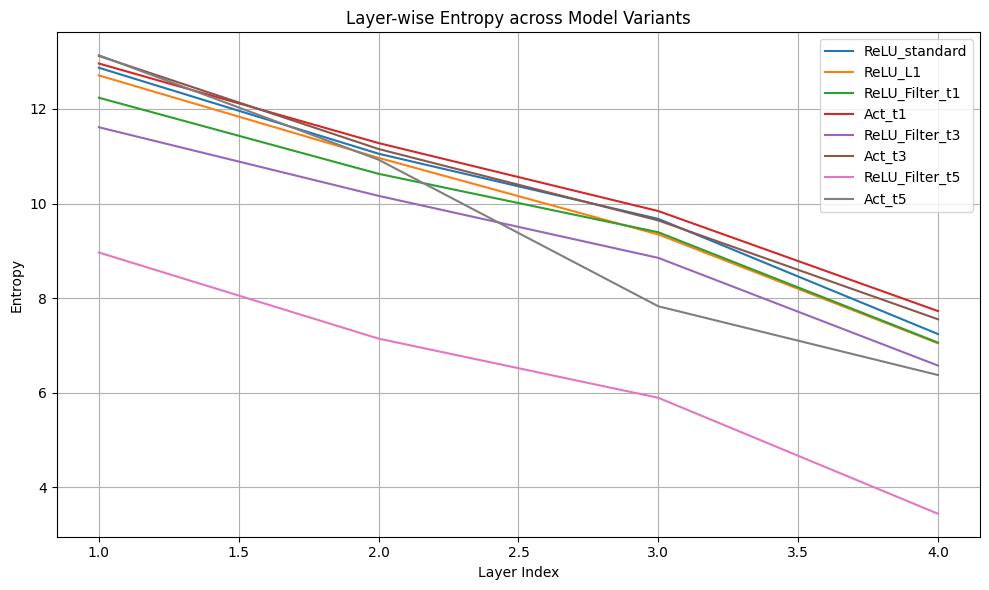

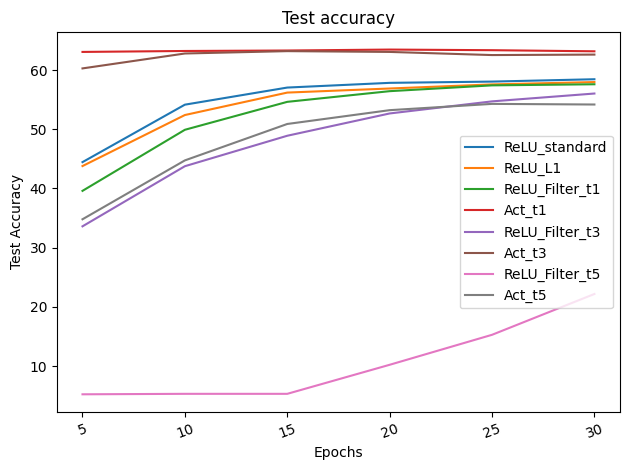

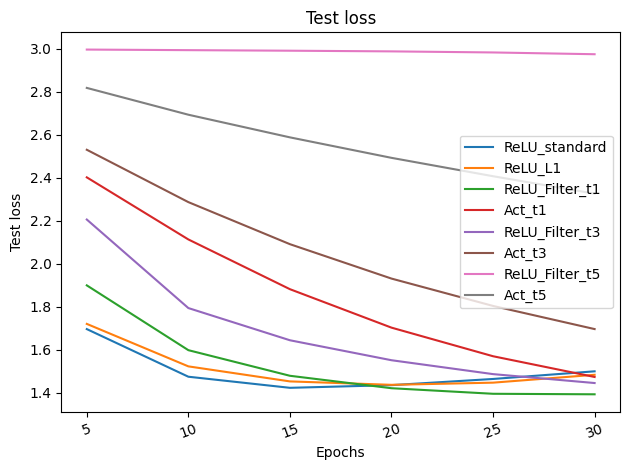

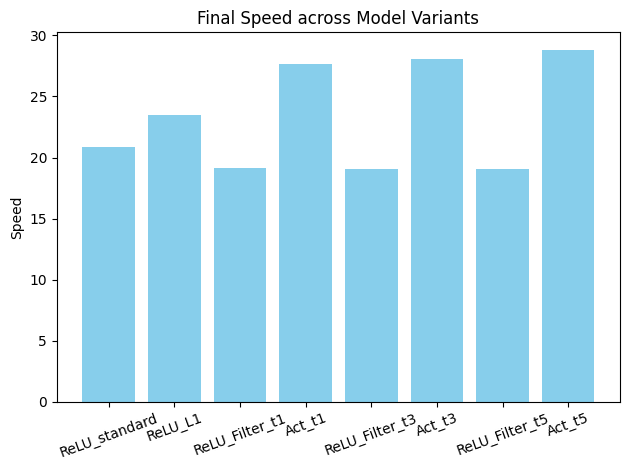

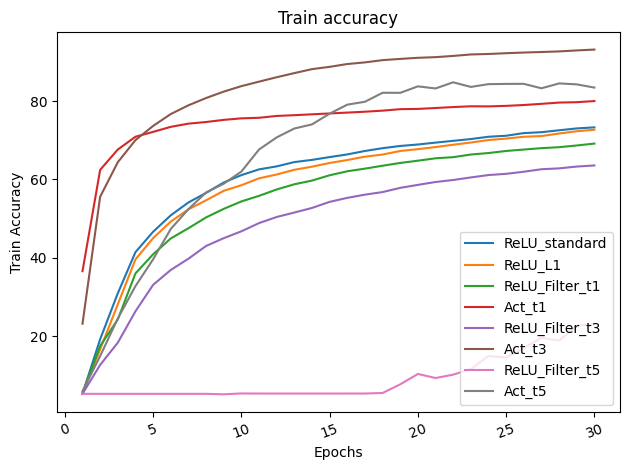

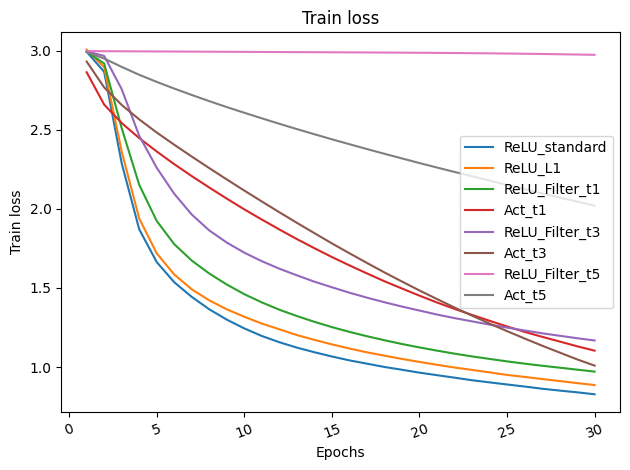

In [18]:
all_entropies = {}
for label, the_model in model_results.items():
    entropies = []
    for name, layer in the_model.named_modules():
        if isinstance(layer, (MaskedLinear)):
            entropies.append(layer.entropy.cpu().item())
    all_entropies[label] = entropies

# Ensure plot directory exists
plot_dir = "runs_"+notebook_name+"/"+str(datetime.now().strftime("%Y%m%d_%H%M%S"))+"_plots"
os.makedirs(plot_dir, exist_ok=True)

# Plotting layer-wise entropy
plt.figure(figsize=(10, 6))
for label, entropies in all_entropies.items():
    plt.plot(range(1, len(entropies)+1), entropies, label=label)
plt.xlabel('Layer Index')
plt.ylabel('Entropy')
plt.title('Layer-wise Entropy across Model Variants')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{plot_dir}/Entropy.png")
plt.show()

# Test accuracy
plt.figure()
for label, accs in test_accs.items():
    plt.plot(range(5, 5 * len(accs) + 1, 5), accs, label=label)
plt.title("Test accuracy")
plt.ylabel('Test Accuracy')
plt.xlabel("Epochs")
plt.xticks(rotation=20)
plt.tight_layout()
plt.legend()
plt.savefig(f"{plot_dir}/Test_Accuracy.png")
plt.show()

# Test loss
plt.figure()
for label, loss in test_losses.items():
    plt.plot(range(5, 5 * len(accs) + 1, 5), loss, label=label)
plt.title("Test loss")
plt.ylabel('Test loss')
plt.xlabel("Epochs")
plt.xticks(rotation=20)
plt.tight_layout()
plt.legend()
plt.savefig(f"{plot_dir}/Test_loss.png")
plt.show()

# Speed
plt.figure()
plt.bar(times.keys(), times.values(), color='skyblue')
plt.ylabel('Speed')
plt.title('Final Speed across Model Variants')
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig(f"{plot_dir}/Speed.png")
plt.show()

# Train accuracy
plt.figure()
for label, accs in train_accs.items():
    plt.plot(range(1, len(accs)+1), accs, label=label)
plt.title("Train accuracy")
plt.ylabel('Train Accuracy')
plt.xlabel("Epochs")
plt.xticks(rotation=20)
plt.tight_layout()
plt.legend()
plt.savefig(f"{plot_dir}/Train_Accuracy.png")
plt.show()

# Train loss
plt.figure()
for label, loss in train_losses.items():
    plt.plot(range(1, len(loss)+1), loss, label=label)
plt.title("Train loss")
plt.ylabel('Train loss')
plt.xlabel("Epochs")
plt.xticks(rotation=20)
plt.tight_layout()
plt.legend()
plt.savefig(f"{plot_dir}/Train_loss.png")
plt.show()


In [19]:
def gini_coefficient(x: np.ndarray) -> float:
    """
    Compute Gini coefficient for a 1D array.
    Assumes non-negative values (e.g., abs(weights)).
    """
    x = np.abs(x.flatten())
    if np.all(x == 0):
        return 0.0  # All zero weights
    x = np.sort(x)
    n = len(x)
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * x)) / (n * np.sum(x)) - (n + 1) / n

def plot_weight_distributions(model=None, weight_data=None, model_name=None, plot_dir="plots"):
    """
    Plot weight and w-value histograms for each layer, either from:
    - a model (with .wval method on layers)
    - OR a dict (state_dict-style) with keys like 'layer.weight' and 'layer.w_values'
    Also prints and includes in plot titles the proportion of zeros and Gini index of the weights.
    """
    if model is None and weight_data is None:
        raise ValueError("Provide either a model or weight_data")

    weight_layers = []
    wval_layers = []
    layer_names = []
    zero_proportions = []
    gini_values = []
    eps = 1e-5

    if weight_data is not None:
        grouped = defaultdict(dict)
        for full_name, tensor in weight_data.items():
            *layer_parts, attr = full_name.split('.')
            layer_name = '.'.join(layer_parts)
            grouped[layer_name][attr] = tensor

        for layer_name, tensors in grouped.items():
            if "weight" in tensors and "w_values" in tensors:
                try:
                    W = tensors["weight"].detach().cpu().flatten().numpy()
                    W_val = tensors["w_values"].detach().cpu().flatten().numpy()
                    weight_layers.append(W)
                    wval_layers.append(W_val)
                    layer_names.append(layer_name)
                    zero_ratio = np.mean(np.abs(W) < eps)
                    gini = gini_coefficient(W)
                    zero_proportions.append(zero_ratio)
                    gini_values.append(gini)
                    print(f"{layer_name}: {zero_ratio:.2%} zeros, Gini: {gini:.4f}")
                except Exception as e:
                    print(f"Skipping {layer_name} due to error: {e}")

    elif model is not None:
        for name, layer in model.named_modules():
            if hasattr(layer, "weight") and hasattr(layer, "w_values"):
                try:
                    W = layer.weight.detach().cpu().flatten().numpy()
                    W_val = layer.w_values.detach().cpu().flatten().numpy()
                    weight_layers.append(W)
                    wval_layers.append(W_val)
                    layer_names.append(name)
                    zero_ratio = np.mean(np.abs(W) < eps)
                    gini = gini_coefficient(W)
                    zero_proportions.append(zero_ratio)
                    gini_values.append(gini)
                    print(f"{name}: {zero_ratio:.2%} zeros, Gini: {gini:.4f}")
                except Exception as e:
                    print(f"Skipping layer {name} due to error: {e}")

    num_layers = len(weight_layers)
    if num_layers == 0:
        print("No valid layers found with both weights and w-values.")
        return

    plt.figure(figsize=(12, 4 * num_layers))

    # Plot weights
    for i, (weights, name, zprop, gini) in enumerate(zip(weight_layers, layer_names, zero_proportions, gini_values)):
        plt.subplot(num_layers, 2, 2 * i + 1)
        sns.histplot(weights, binwidth=0.01, kde=False, color='steelblue')
        plt.title(f"{name} - Weights\nZero %: {zprop:.2%} | Gini: {gini:.4f}")
        plt.xlabel("Weight Value")
        plt.ylabel("Frequency")
        plt.xlim([-1, 1])

    # Plot w-values
    for i, (wvals, name) in enumerate(zip(wval_layers, layer_names)):
        plt.subplot(num_layers, 2, 2 * i + 2)
        sns.histplot(wvals, binwidth=0.1, kde=False, color='darkorange')
        plt.title(f"{name} - W-Values")
        plt.xlabel("W-Value")
        plt.ylabel("Frequency")
        plt.xlim([0, 4])

    plt.tight_layout()
    plt.savefig(f"{plot_dir}-{model_name}-W_WVs.png")
    plt.show()


In [20]:
models_list = [label for label, _, _, _,  _, _, _,  _, _, _, in configs]

model.0: 0.03% zeros, Gini: 0.4475
model.2: 0.01% zeros, Gini: 0.4201
model.4: 0.03% zeros, Gini: 0.4055
model.6: 0.04% zeros, Gini: 0.3843


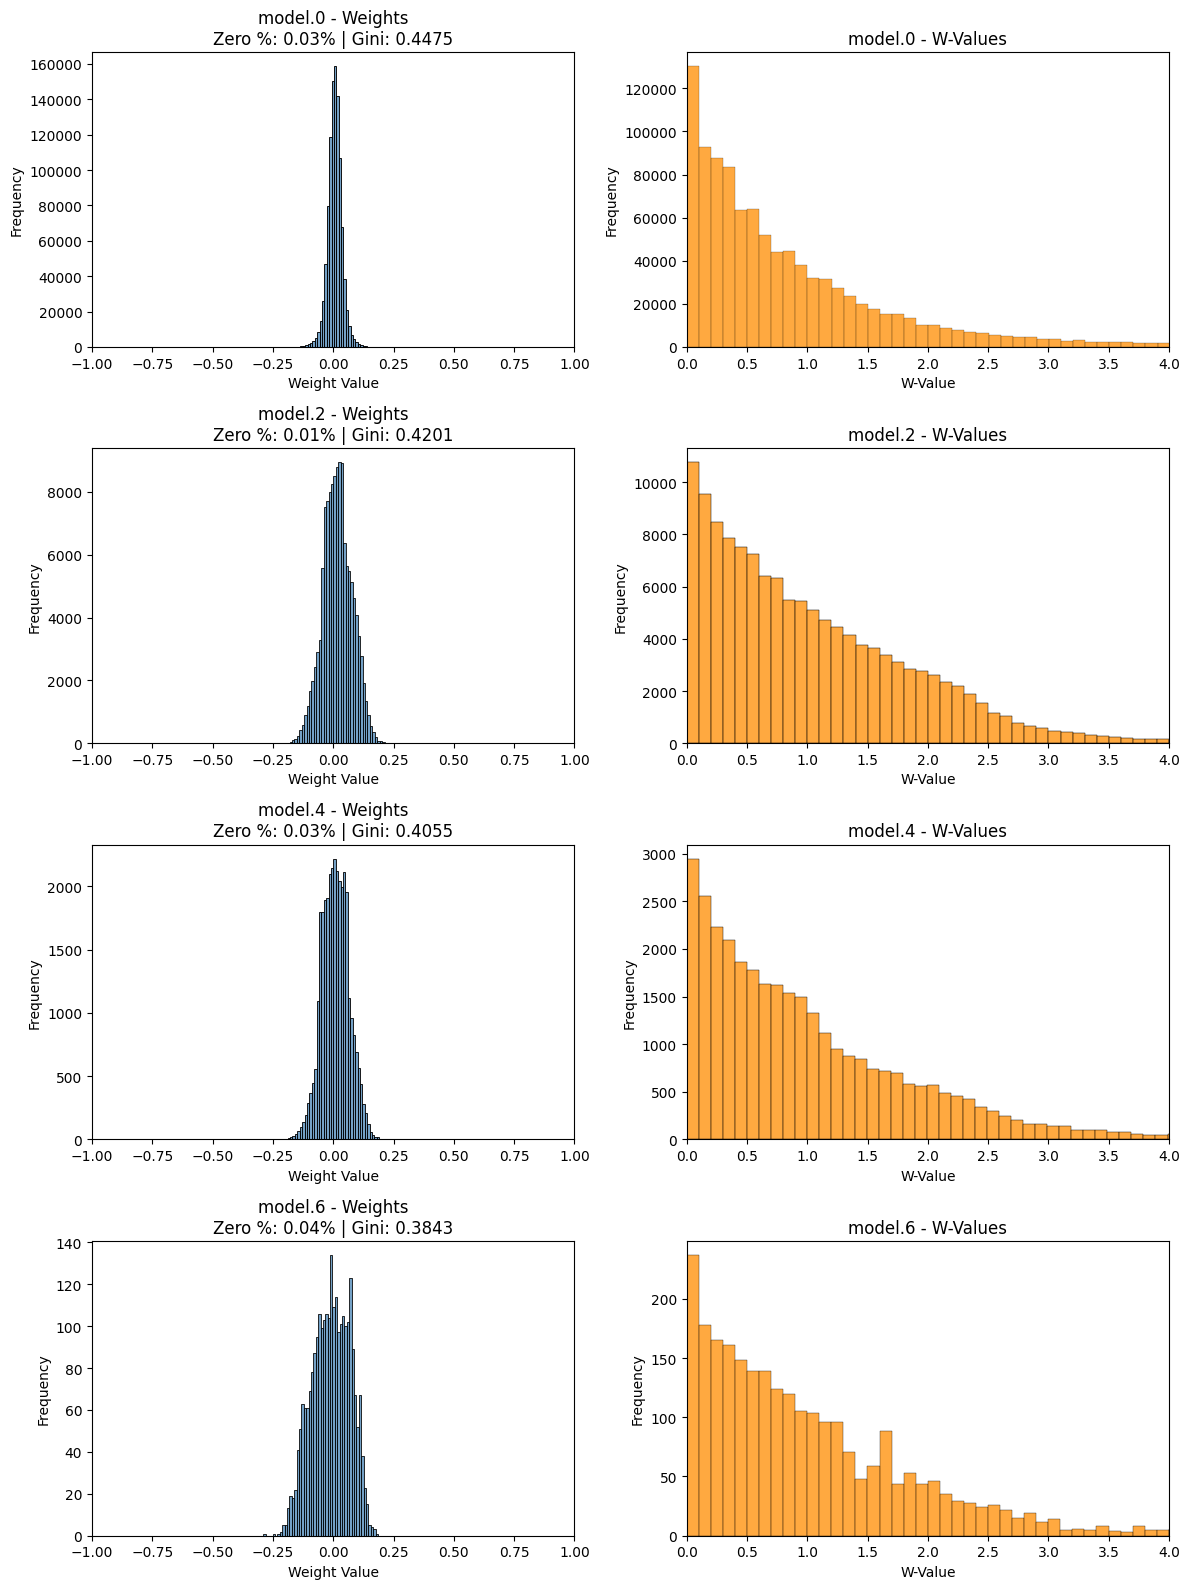

model.0: 1.22% zeros, Gini: 0.4876
model.2: 10.07% zeros, Gini: 0.4995
model.4: 16.30% zeros, Gini: 0.5856
model.6: 3.52% zeros, Gini: 0.4853


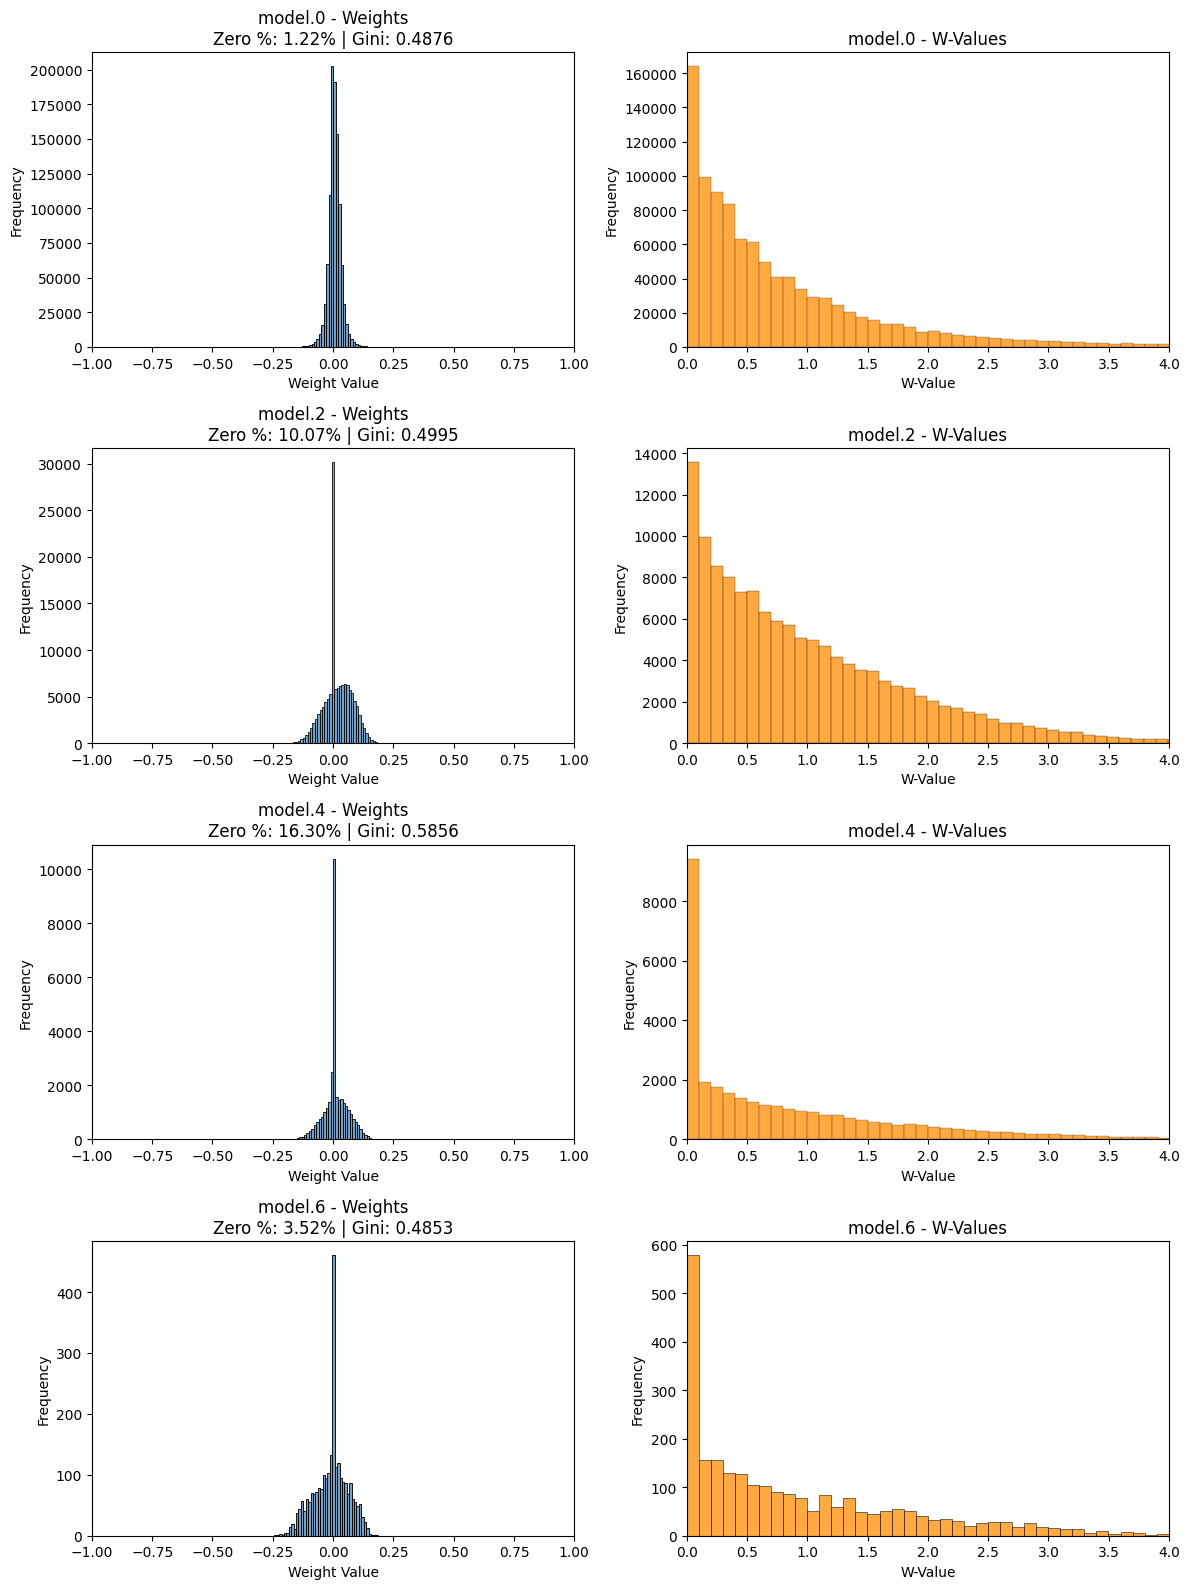

model.0: 0.06% zeros, Gini: 0.6595
model.2: 0.03% zeros, Gini: 0.6013
model.4: 0.01% zeros, Gini: 0.5106
model.6: 0.04% zeros, Gini: 0.4686


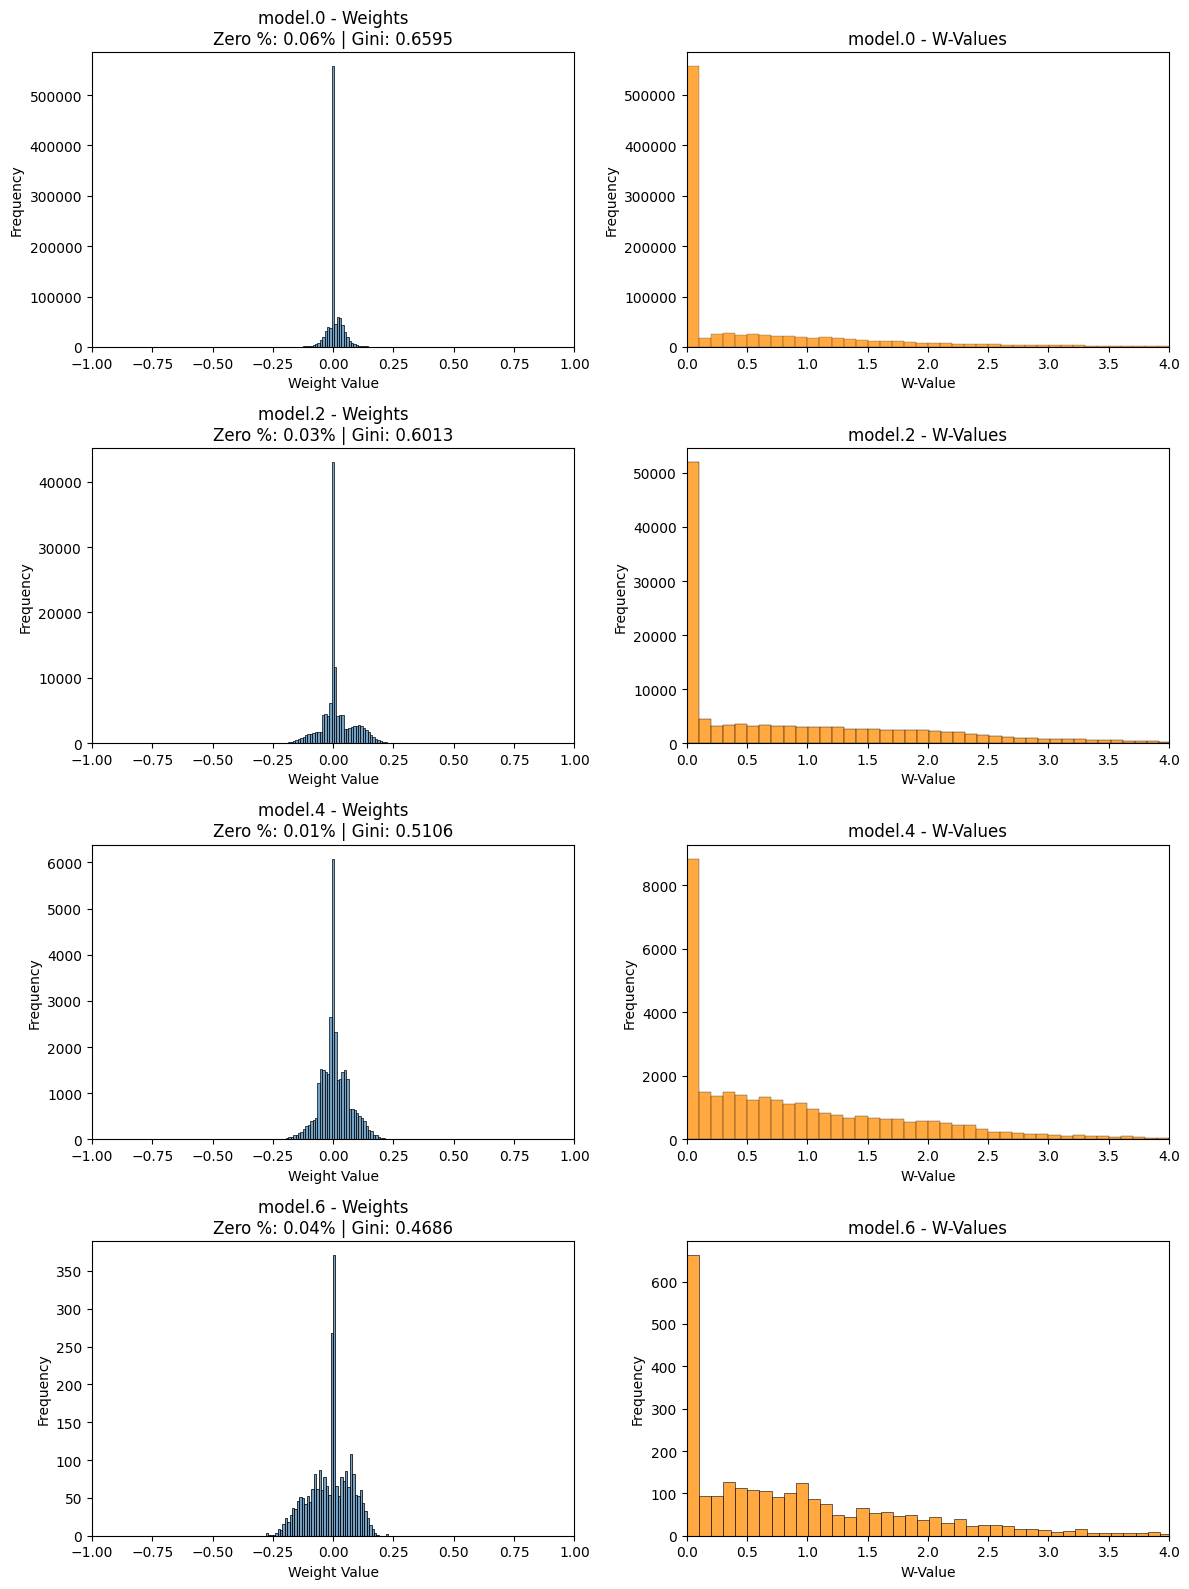

model.0: 0.05% zeros, Gini: 0.4107
model.2: 0.03% zeros, Gini: 0.3542
model.4: 0.02% zeros, Gini: 0.3696
model.6: 0.00% zeros, Gini: 0.1498


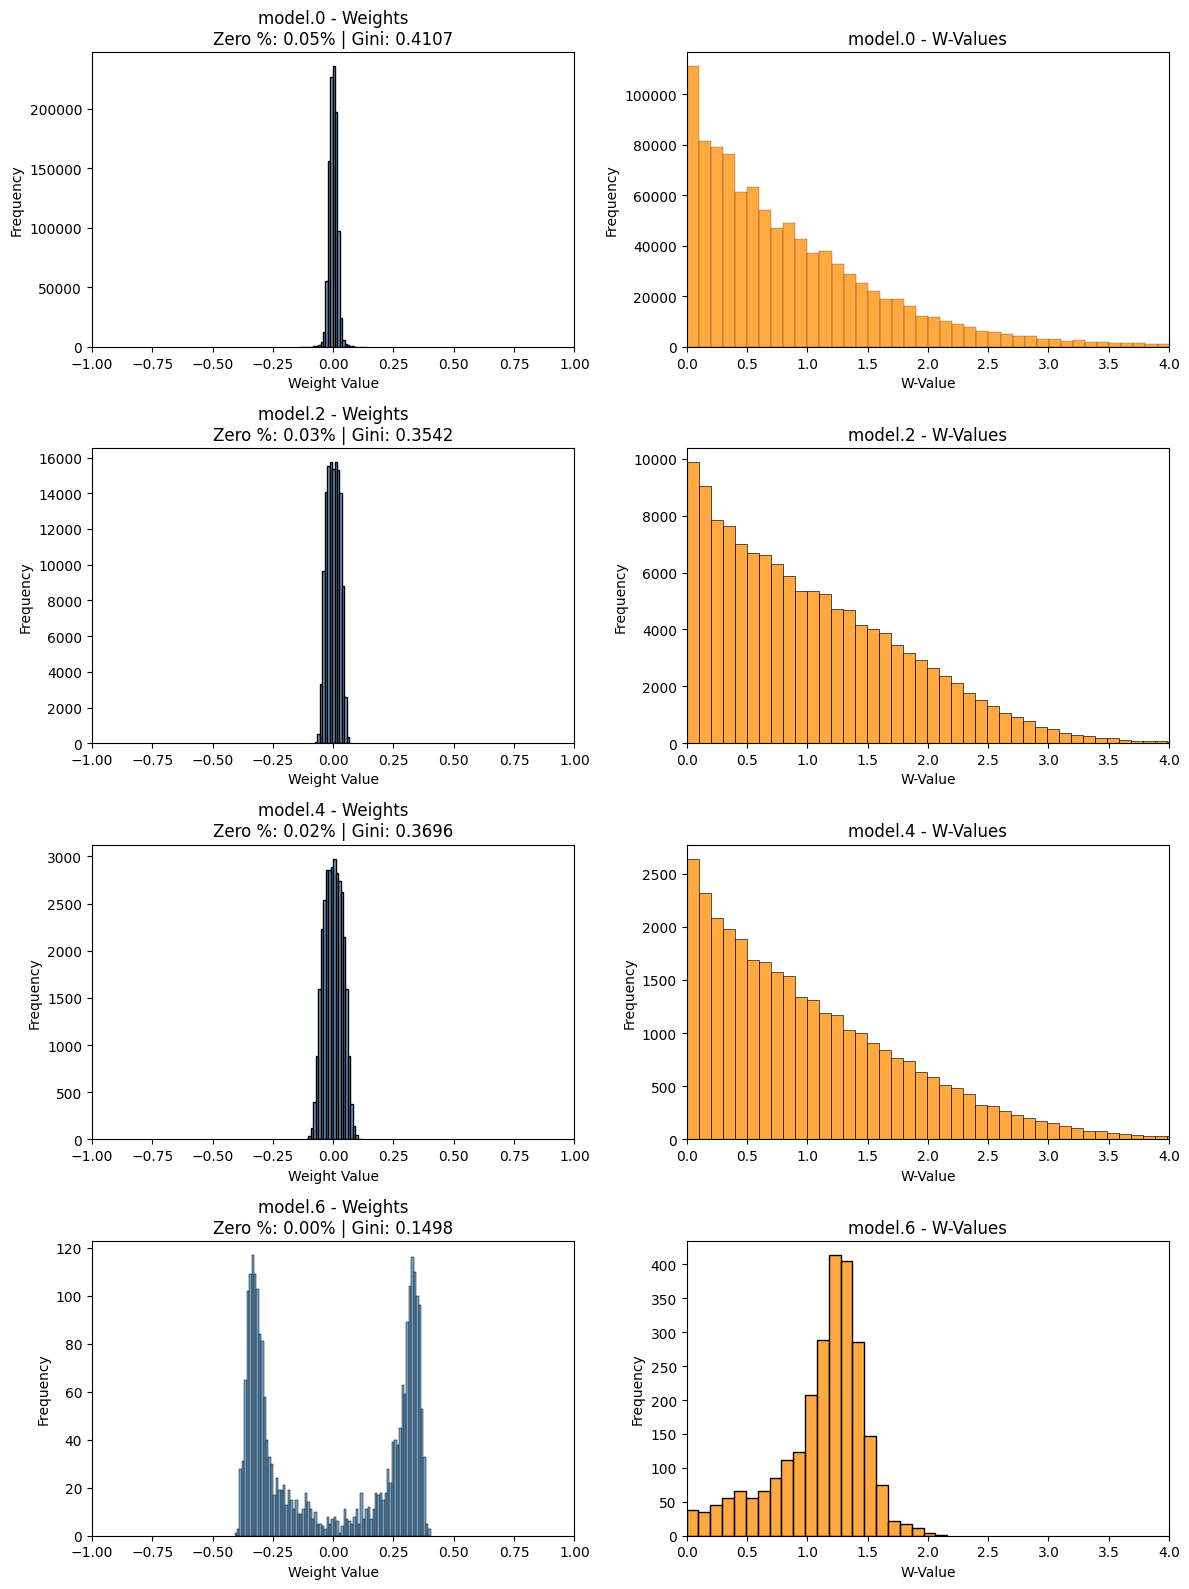

model.0: 0.05% zeros, Gini: 0.5876
model.2: 0.03% zeros, Gini: 0.5885
model.4: 0.01% zeros, Gini: 0.5020
model.6: 0.04% zeros, Gini: 0.4930


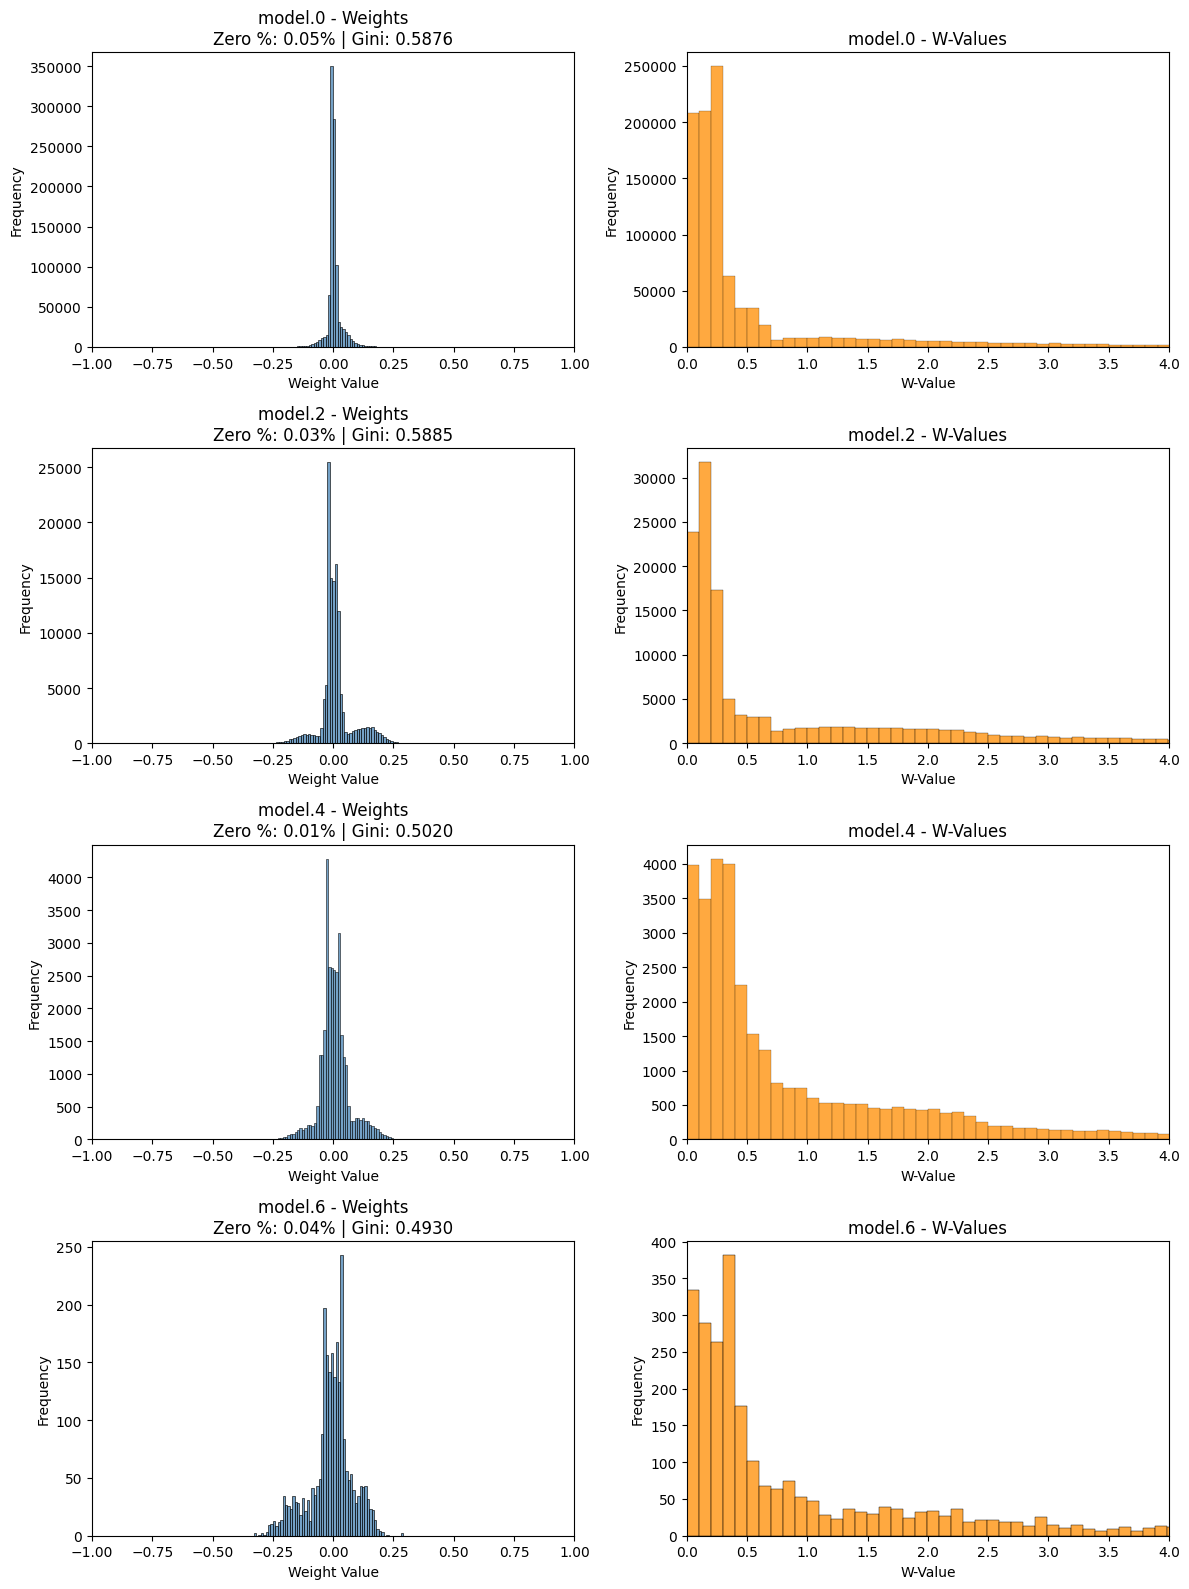

model.0: 0.05% zeros, Gini: 0.4064
model.2: 0.02% zeros, Gini: 0.3900
model.4: 0.03% zeros, Gini: 0.4224
model.6: 0.00% zeros, Gini: 0.2647


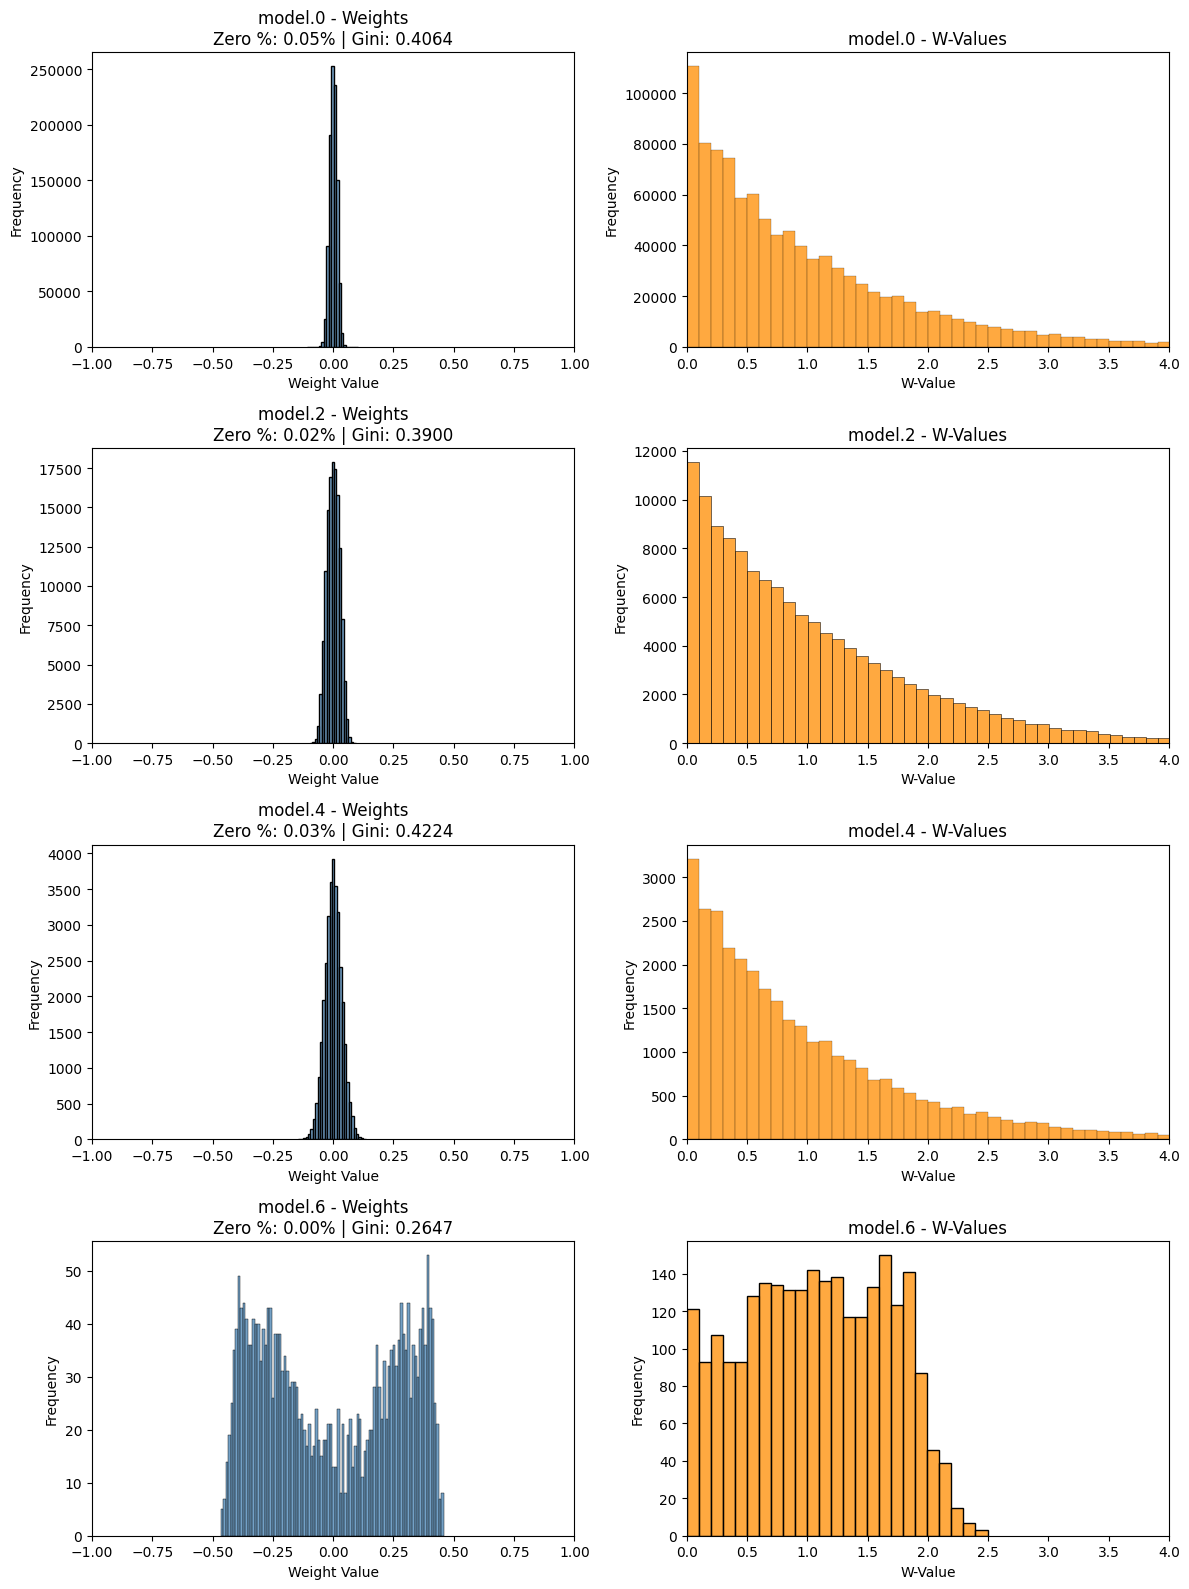

model.0: 0.05% zeros, Gini: 0.4139
model.2: 0.03% zeros, Gini: 0.3775
model.4: 0.01% zeros, Gini: 0.3464
model.6: 0.04% zeros, Gini: 0.3725


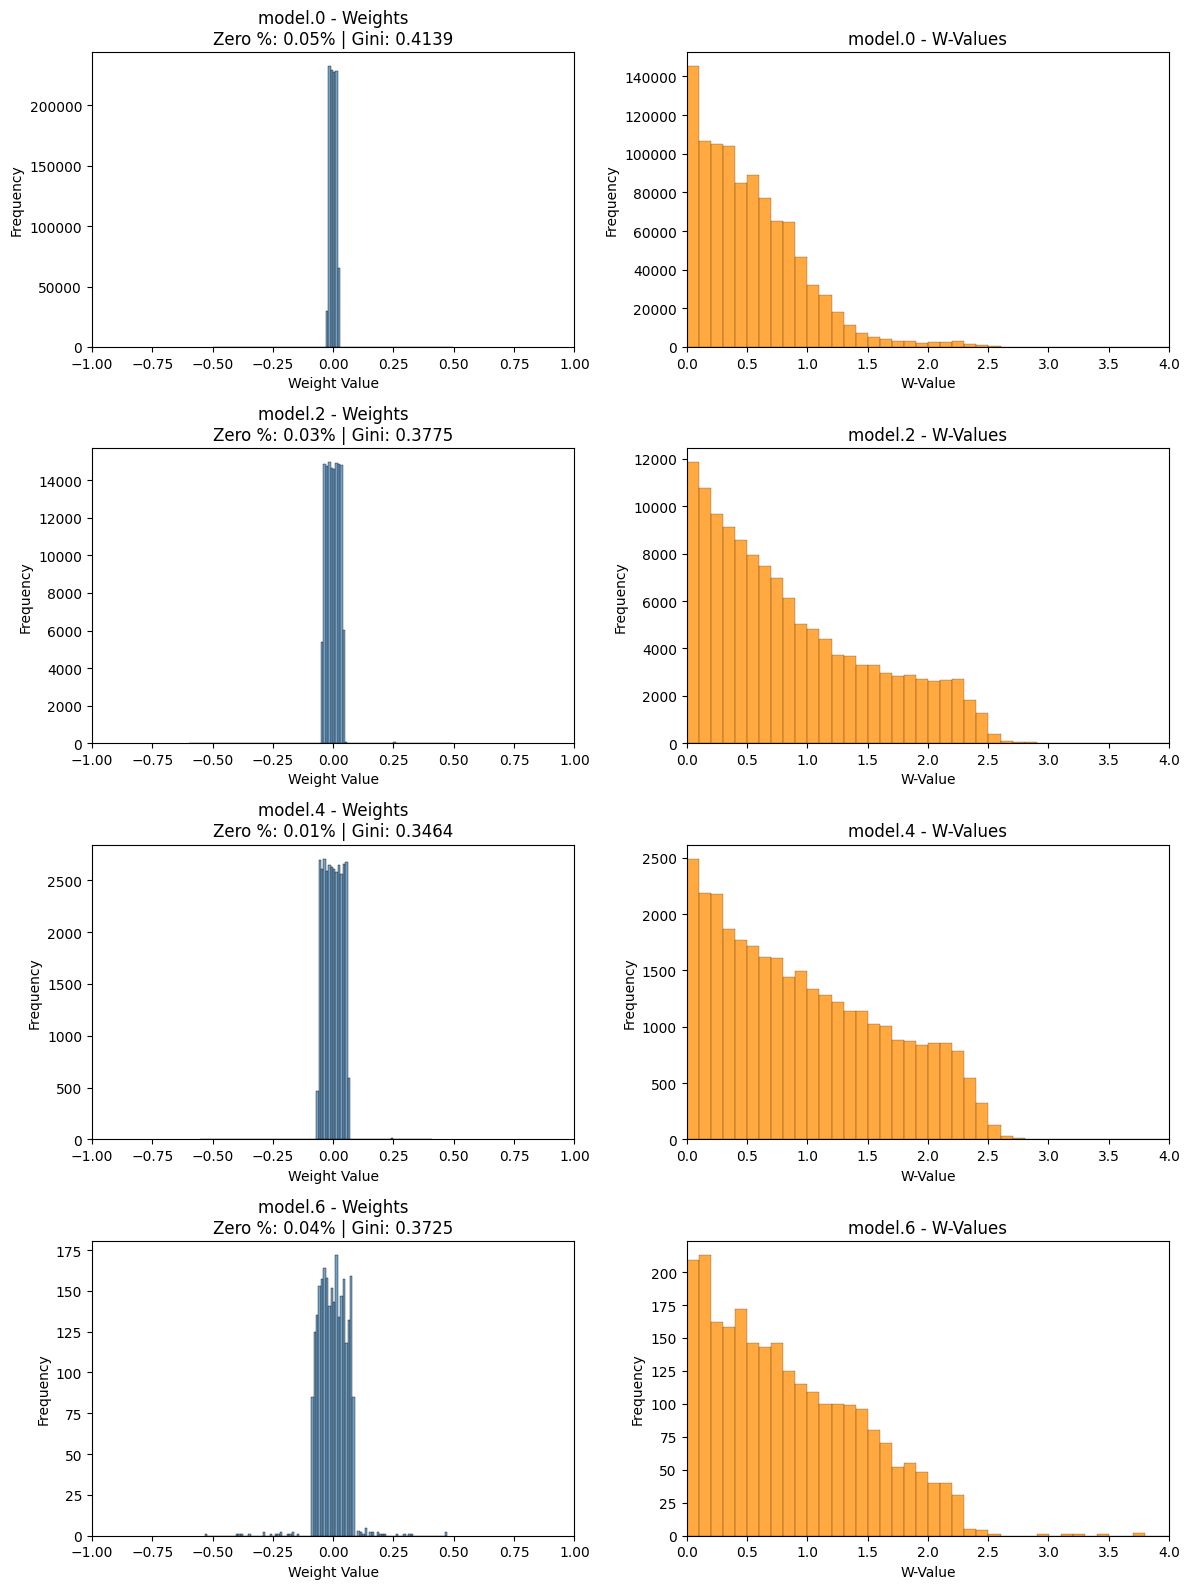

model.0: 0.05% zeros, Gini: 0.4024
model.2: 0.04% zeros, Gini: 0.4160
model.4: 14.36% zeros, Gini: 0.8620
model.6: 0.00% zeros, Gini: 0.5635


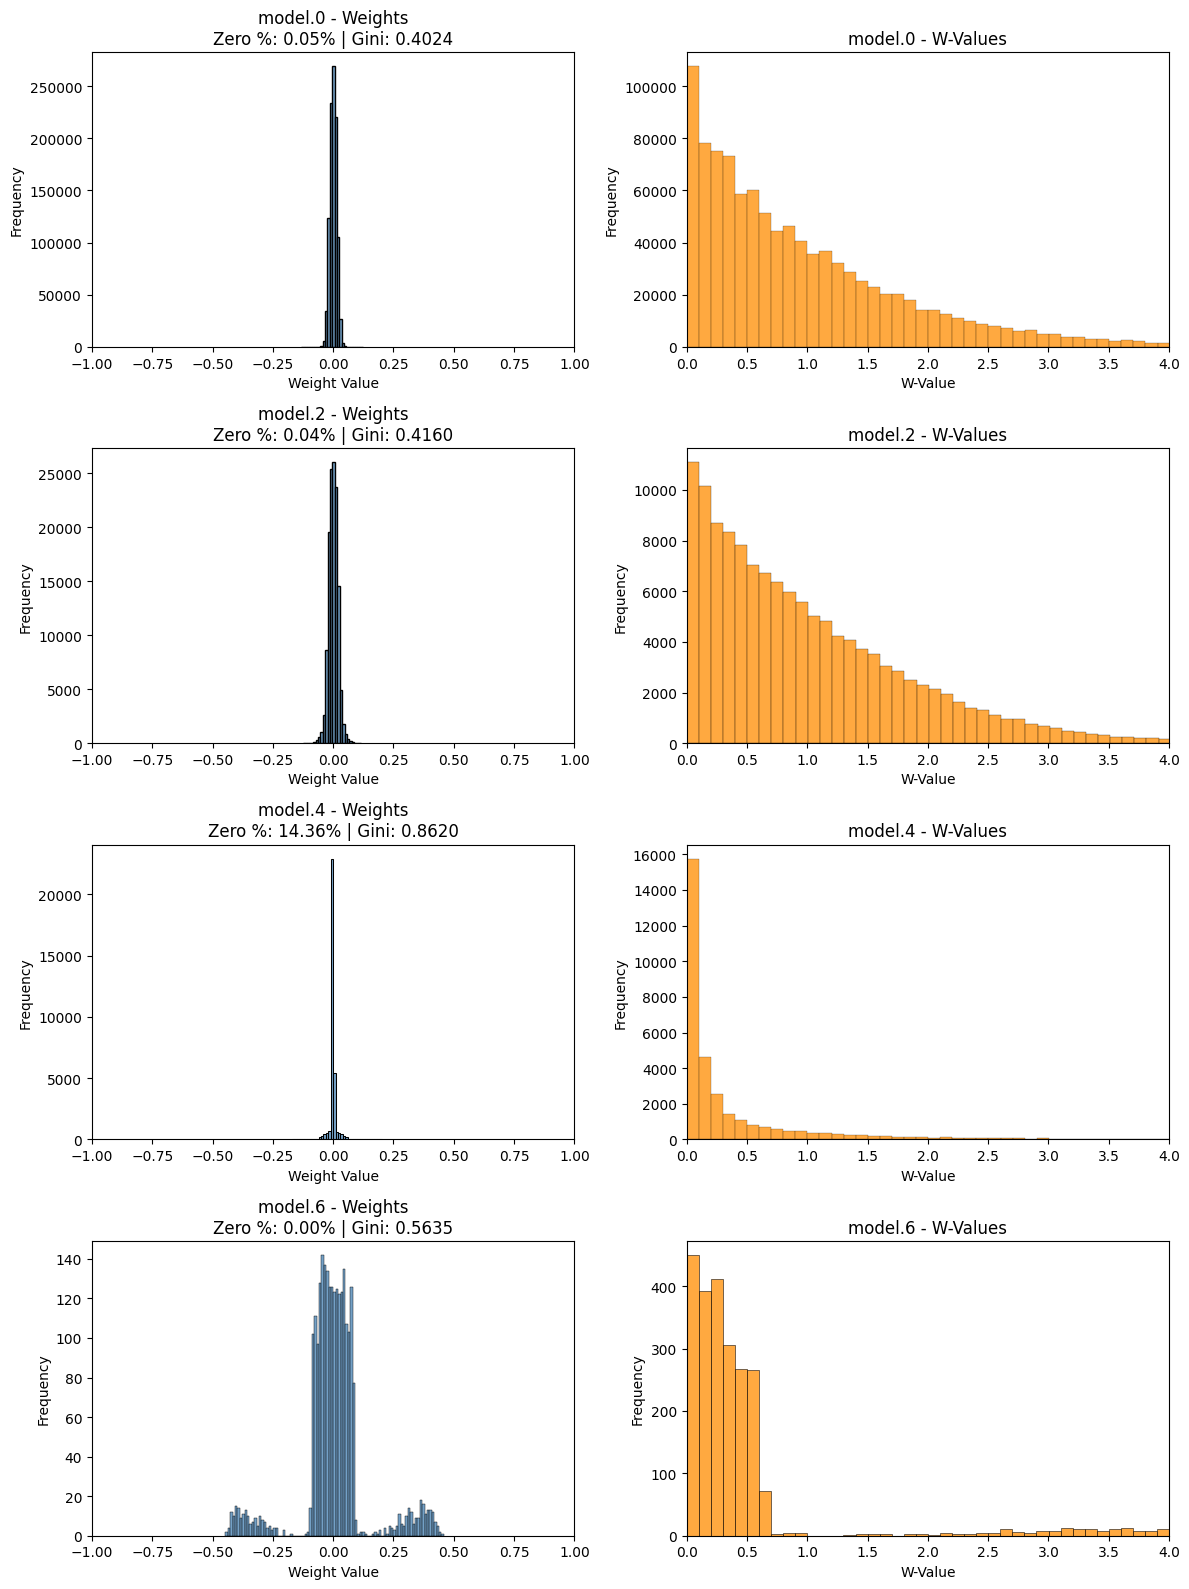

In [21]:
for model in models_list:
    plot_weight_distributions(model=model_results[model], model_name=model)